### LOADING ALL THE SUBJECTS' FOOOF RESULTS IN A DICT 

In [ ]:
import numpy as np
import pandas as pd
from fooof.utils.io import load_fooofgroup as load_fooofgroup
from natsort import natsorted 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 14})
from scipy.stats import spearmanr
import pickle
from enigmatoolbox.utils.parcellation import parcel_to_surface
from enigmatoolbox.plotting import plot_cortical
import re
from data_utils import reorganize_rois, reorder_hemispheres, compare_slopes

In [2]:
### LOADING ROIs NAME FROM EEGLAB DESIKAN ATLAS ###
labels = pd.read_excel('G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\Foof_res\\Desikan_regions.xlsx').values.tolist()
labels = [parcel_name[0].replace("'", "") for parcel_name in labels]
print(f'ROIs names: {labels}')

ROIs names: ['bankssts L', 'bankssts R', 'caudalanteriorcingulate L', 'caudalanteriorcingulate R', 'caudalmiddlefrontal L', 'caudalmiddlefrontal R', 'cuneus L', 'cuneus R', 'entorhinal L', 'entorhinal R', 'frontalpole L', 'frontalpole R', 'fusiform L', 'fusiform R', 'inferiorparietal L', 'inferiorparietal R', 'inferiortemporal L', 'inferiortemporal R', 'insula L', 'insula R', 'isthmuscingulate L', 'isthmuscingulate R', 'lateraloccipital L', 'lateraloccipital R', 'lateralorbitofrontal L', 'lateralorbitofrontal R', 'lingual L', 'lingual R', 'medialorbitofrontal L', 'medialorbitofrontal R', 'middletemporal L', 'middletemporal R', 'paracentral L', 'paracentral R', 'parahippocampal L', 'parahippocampal R', 'parsopercularis L', 'parsopercularis R', 'parsorbitalis L', 'parsorbitalis R', 'parstriangularis L', 'parstriangularis R', 'pericalcarine L', 'pericalcarine R', 'postcentral L', 'postcentral R', 'posteriorcingulate L', 'posteriorcingulate R', 'precentral L', 'precentral R', 'precuneus L'

#### CREATING A DICT WITH fooof VALUES ####

In [ ]:
#data_dict = load_aperiodic_from_mat_files("path/that/contains/mat/fooof/data", aperiodic_component = 'exponent')

#### LOADING THE ALREADY CREATED FOOOF EXP DICT ####

In [3]:
###### LOADING THE ALREADY SAVED DICTIONARY CONTAINING APERIODIC EXPONENTS ######
# Load the dictionary from the file
with open("G:\Drive condivisi\AnalisiSegnaliEeg\HD EEG\Crisi_HDEEG\Foof_res_correct\Fooof_exponents.pkl", 'rb') as file:
    data_dict = pickle.load(file)

#### CREATING AN ARRAY FROM THE DICT FOR SUCCESSIVE PLOTS ####

In [4]:
exponent_list_corrected = np.array(list(data_dict.values()))
print(f'Exponent list removing first fooof new shape {exponent_list_corrected.shape}')
### CALCULAING THE AVERAGE FOOOF x ROI APERIODIC EXPONENT ###
average_fooof = np.mean(exponent_list_corrected, axis=0)
print(f'Average per ROIs FOOOF array shape {average_fooof.shape}')
average_fooof_in_time = np.mean(average_fooof, axis=1)
print(f'Averaged per subject and per time FOOOF array shape {average_fooof_in_time.shape}')

Exponent list removing first fooof new shape (29, 68, 120)
Average per ROIs FOOOF array shape (68, 120)
Averaged per subject and per time FOOOF array shape (68,)


Text(0.5, 1.0, 'Plot of Averaged Time Series')

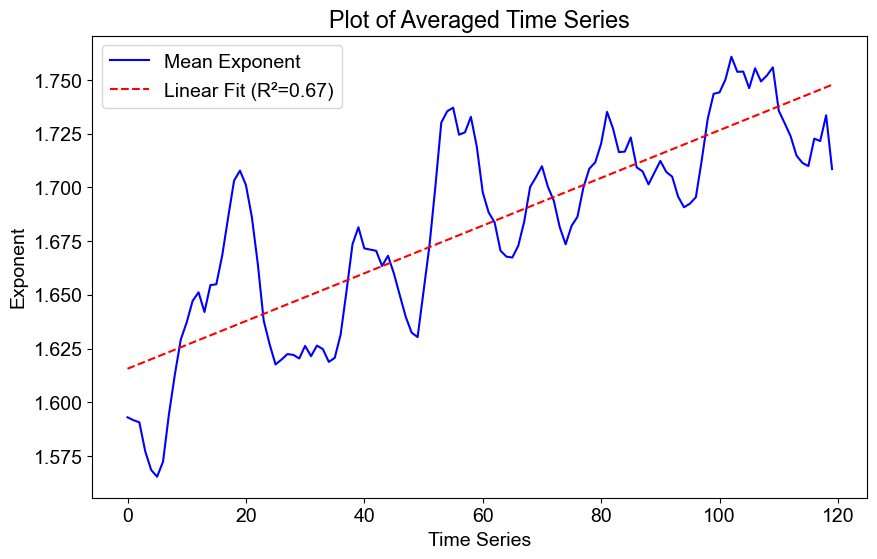

In [5]:
data = np.array(exponent_list_corrected, dtype=np.float64)
# Compute mean and standard deviation across axis 0
x_values = np.arange(data.shape[2])
mean_series = np.mean(data, axis=(0, 1))# Linear Fit

# Compute linear fit
coeffs = np.polyfit(x_values, mean_series, 1)  # Fit degree-1 polynomial (y = mx + c)
y_fit = np.polyval(coeffs, x_values)  # Evaluate polynomial

# Compute R²
from sklearn.metrics import r2_score
r_squared = r2_score(mean_series, y_fit)

# Plot the averaged data
plt.figure(figsize=(10, 6))
plt.plot(x_values, mean_series, label="Mean Exponent", color="blue")

# Plot the linear fit
plt.plot(x_values, y_fit, linestyle="--", color="red", label=f'Linear Fit (R²={r_squared:.2f})')

# Labels and title
plt.xlabel("Time Series")
plt.ylabel("Exponent")
plt.legend()
plt.title("Plot of Averaged Time Series")

#### AVERAGE OF RELEVANT ROIs FOR DIAGNOSES vs NOT RELEVANT ONES ####


In [6]:
### LOADING EXCEL FILE WITH THE INDICES OF RELEVANT ROIs x SUBJECT ###
file_path = "G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\PLOTS\\relevant_rois_indices.xlsx" 
df_relevant_rois = pd.read_excel(file_path)
# Extract indices and IDs
list_indices =  list(zip(df_relevant_rois["ID"].tolist(), list(df_relevant_rois["INDICES_strict"].tolist())))

In [7]:
def process_fooof_exp(fooof_dict, list_indices, normalized="per ROIs"):
    """
    Process and normalize FOOOF data for selected and non-selected ROIs.

    Parameters
    ----------
    fooof_dict : dict
        Dictionary where keys are subject IDs and values are 2D NumPy arrays of shape (n_ROIs, n_features),
        representing FOOOF-derived data per ROI.
    
    list_indices : list of tuples
        Each tuple contains a subject ID and a string of comma-separated ROI indices (e.g., "0,1,2") 
        to be selected for that subject.

    normalized : str, optional
        Method for normalization. Must be one of:
        - 'none' : No normalization is applied.
        - 'per ROIs' : Global z-score normalization across all subjects and ROIs (default).
        - 'per subject' : Z-score normalization is applied separately for each subject.

    Returns
    -------
    avg_selected : dict
        Dictionary where keys are subject IDs and values are NumPy arrays containing the normalized
        FOOOF data for the selected ROIs.

    avg_not_selected : dict
        Dictionary where keys are subject IDs and values are NumPy arrays containing the normalized
        FOOOF data for the non-selected ROIs.
    """
    valid_normalization_options = {"none", "per ROIs", "per subject"}
    if normalized not in valid_normalization_options:
        raise ValueError(f"Invalid normalization option '{normalized}'. Choose from {valid_normalization_options}.")
    
    avg_selected , avg_not_selected = {}, {}
    # Process each ID and its corresponding indices
    for ID, indices in list_indices:
        ID = re.sub(r'_(?=[^_]*_sz)', '-', ID)
        if ID in fooof_dict:
            matrix = fooof_dict[ID]  # Shape (68, 120)

            # Convert indices from string to list of integers
            selected_indices = list(map(int, indices.split(",")))
            # Select columns corresponding to the indices
            selected_values = matrix[selected_indices, :]  # Shape (selected_indices, 120)
            not_selected_values = np.delete(matrix, selected_indices, axis=0)  # Remaining columns
            del matrix
            # Compute averages
            avg_selected[ID] = selected_values
            avg_not_selected[ID] = not_selected_values
            del selected_values, not_selected_values
    
    if normalized == "per ROIs":
        # Flatten all data into a single array for global mean/std
        all_selected_values = np.concatenate([values.reshape(-1) for values in avg_selected.values()])
        all_not_selected_values = np.concatenate([values.reshape(-1) for values in avg_not_selected.values()])

        # Compute global mean and std
        mean_all_selected, std_all_selected = np.mean(all_selected_values), np.std(all_selected_values)
        mean_all_not_selected, std_all_not_selected = np.mean(all_not_selected_values), np.std(all_not_selected_values)

        # Apply z-score normalization across all subjects
        for key in avg_selected:
            avg_selected[key] = (avg_selected[key] - mean_all_selected) / std_all_selected
        for key in avg_not_selected:
            avg_not_selected[key] = (avg_not_selected[key] - mean_all_not_selected) / std_all_not_selected

    elif normalized == "per subject":
        # Normalize each subject separately
        for key in avg_selected:
            mean_selected, std_selected = np.mean(avg_selected[key]), np.std(avg_selected[key])
            avg_selected[key] = (avg_selected[key] - mean_selected) / std_selected

        for key in avg_not_selected:
            mean_not_selected, std_not_selected = np.mean(avg_not_selected[key]), np.std(avg_not_selected[key])
            avg_not_selected[key] = (avg_not_selected[key] - mean_not_selected) / std_not_selected
    
    return avg_selected, avg_not_selected

In [8]:
exp_selected, exp_non_selected = process_fooof_exp(data_dict, list_indices, normalized='none') # dicts with 29 keys (number of EEG recordings) and values of shape (n, 120)

# average of concatenated dict values on keys axis in order to obtain an array of shape (120,)
exp_selected_average, exp_non_selected_average = np.mean(np.concatenate(list(exp_selected.values()), axis=0), axis = 0), np.mean(np.concatenate(list(exp_non_selected.values()), axis=0), axis = 0)

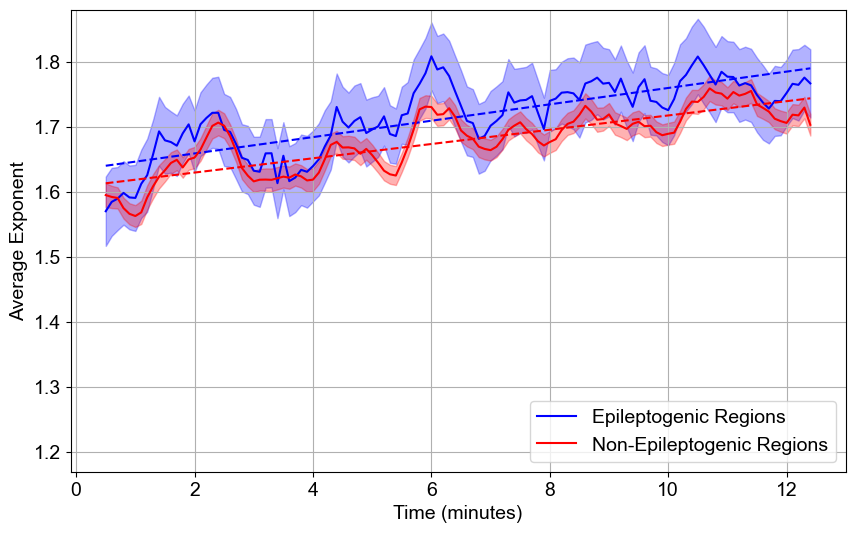

In [9]:
se_selected, se_not_selected = [value for key, value in exp_selected.items()], [value for key, value in exp_non_selected.items()]
flattened_selected, flattened_not_selected = np.array([row for sublist in se_selected for row in sublist]), np.array([row for sublist in se_not_selected for row in sublist])

se_selected = np.std(flattened_selected, axis=0, ddof=1) / np.sqrt(flattened_selected.shape[0])
se_not_selected = np.std(flattened_not_selected, axis=0, ddof=1) / np.sqrt(flattened_not_selected.shape[0])

# Parameters to convert fooof windows in time (minutes)
sampling_rate = 256  # Hz
signal_duration_sec = 13 * 60  # 780 seconds
window_length_sec = 60
step_size_sec = window_length_sec * (1 - 0.9)  # 6 seconds
num_segments = 121  # already known

# Generate time vector (window centers) in seconds
window_start_times = np.arange(0, step_size_sec * num_segments, step_size_sec)
window_center_times = window_start_times + (window_length_sec / 2)

# Convert to minutes
window_center_times_min = (window_center_times / 60)[:120]

# Plot the two time series
plt.figure(figsize=(10, 6))

# Plot Selected Indices with std 
x1 = window_center_times_min
plt.plot(x1, exp_selected_average, label="Epileptogenic Regions", color="blue")
plt.fill_between(x1, exp_selected_average - se_selected, exp_selected_average + se_selected, color='blue', alpha=0.3)

coeffs_sel = np.polyfit(x1, exp_selected_average, 1)
plt.plot(x1, np.polyval(coeffs_sel, x1), linestyle='--', color='blue')

# Plot Non-Selected Indices with std 
x2 = window_center_times_min
plt.plot(x2, exp_non_selected_average, label="Non-Epileptogenic Regions", color="red")
plt.fill_between(x2, exp_non_selected_average - se_not_selected, exp_non_selected_average + se_not_selected, color='red', alpha=0.3)

coeffs_non = np.polyfit(x2, exp_non_selected_average, 1)
plt.plot(x2, np.polyval(coeffs_non, x2), linestyle='--', color='red')

# Add labels and legend
plt.xlabel("Time (minutes)")
plt.ylabel("Average Exponent")
#plt.title("Pre-ictal")
plt.legend(loc = 'lower right')
plt.grid(True)

plt.ylim(1.17,1.88)
plt.show()

#### NEUROTRANSMITTER ANALYSIS ####

In [ ]:
data_path = "G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\DATA\\" #path/to/neurotransmitters/data/folder
neurotransmitter_df = pd.read_excel(data_path + "region_info_Labels_Desik_neurotrans.xlsx")

In [13]:
# Create a copy of the label column
neurotransmitter_atlas = neurotransmitter_df['label'].copy()

# Modify only the relevant labels where 'structure' is 'cortex' in order to be comparable to the Desikan atlas
neurotransmitter_atlas = neurotransmitter_df.loc[neurotransmitter_df['structure'] == 'cortex', 'label'] + ' ' + neurotransmitter_df.loc[neurotransmitter_df['structure'] == 'cortex', 'hemisphere']

In [14]:
#### Desikan brainstorm labels follow an alphabetical order, so we have to change order of neurotransmitter data in order to follow same order ####
def is_alphabetical(arr):
    return arr == sorted(arr)

# Create a dictionary mapping each item in reference to its index
map_nts_to_brainstorm = {value: i for i, value in enumerate(neurotransmitter_atlas)}

# Generate a list of indices to reorder target to match reference
map_nts_to_brainstorm = [map_nts_to_brainstorm[item] for item in labels if item in map_nts_to_brainstorm] ### obtained list of indices that allows us to go from  
                                                                                                          ### desikan neurotransmitter order to brainstorm desikan order

In [15]:
### loading neurotransmitter column data from .npy file
neurotransmitter_names = np.load(data_path + "receptor_names_pet.npy")
print(neurotransmitter_names)

### load csv file that contains neurotransmitters data with column names equal to neurotransmitter_names
neurotransmitter_data = pd.read_csv(data_path + "receptor_data_Desik_neurotrans.csv", names = neurotransmitter_names)

['5HT1a' '5HT1b' '5HT2a' '5HT4' '5HT6' '5HTT' 'A4B2' 'CB1' 'D1' 'D2' 'DAT'
 'GABAa' 'H3' 'M1' 'mGluR5' 'MOR' 'NET' 'NMDA' 'VAChT']


In [16]:
seratonin = ["5HT1a", "5HT1b", "5HT2a", "5HT4", "5HT6", "5HTT"]
acetylcholine = ["A4B2", "M1", "VAChT"]
GABA = ['GABAa']
NMDA = ["NMDA"]
cannabinoid = ["CB1"]
opioid = ["MOR"]

neurotransmitters = seratonin + acetylcholine + GABA + NMDA + cannabinoid + opioid

#### M1 RECEPTORS DISTRIBUTION CORTICAL PLOT

In [17]:
M1_nts_brainstorm_order = neurotransmitter_data['M1'][map_nts_to_brainstorm]

In [ ]:
# PLOTTING M1 NEUTOTRANSMITTER RECEPTORS DISTRIBUTION ON CORTICAL SURFACE
reorganized_plot = parcel_to_surface(reorganize_rois(reorder_hemispheres(M1_nts_brainstorm_order)), 'aparc_fsa5', fill= np.nan)

# Apply transformations (from eeglab indices order to enigmatoolbox order)
# Generate the cortical plot and save as an image
plot_cortical(array_name=reorganized_plot, surface_name="fsa5", size=(1500, 700), background=(1,1,1), transparent_bg=False,
              cmap='viridis', nan_color=(1, 1, 1, 1), color_bar=True, scale=(1,1), zoom=1.25, color_range=(min(M1_nts_brainstorm_order),max(M1_nts_brainstorm_order)), 
              interactive = False, screenshot=False)


#### CORRELATION BETWEEN AVERAGE PRE-ICTAL FOOOF and NEUROTRANSMITTERS RECEPTORS


In [18]:
average_fooof_per_time = np.mean(average_fooof, axis=1) #obtain average fooof in time for each ROI (shape 68)

nts_fooof_correlation = {}
for nt in neurotransmitters:
  vector = neurotransmitter_data[nt].to_numpy()
  cor, pval = spearmanr(average_fooof_per_time, vector[map_nts_to_brainstorm])
  nts_fooof_correlation[nt] = (cor, pval)

In [ ]:
from enigmatoolbox.permutation_testing import spin_test
corr_fooof_nts_ic_1000 = {}

map1 = average_fooof_per_time # differece between slopes resting - interictal
map2 =  neurotransmitter_data # neurotrasmitters expression  

# Set parameters
n_rot = 1000
surface = 'fsa5'
parcellation = 'aparc'

for i in neurotransmitters:
    nt_for_spin = map2[i].values
    # Perform spin test
    r_empirical, _ = spearmanr(map1, nt_for_spin[map_nts_to_brainstorm])
    p_val = spin_test(
        reorganize_rois(reorder_hemispheres(map1)),
        reorganize_rois(reorder_hemispheres(nt_for_spin[map_nts_to_brainstorm])),
        n_rot=n_rot,
        surface_name=surface,
        parcellation_name=parcellation,
        type='spearman'
    )
    
    corr_fooof_nts_ic_1000[i] = {
        'r_empirical' : r_empirical,
        'p_value_spin': p_val}

##### FDR CORRECTION OF SPIN PERMUTED PVALUES

In [91]:
corr_fooof_nts_ic_1000

from mne.stats import fdr_correction

correction_spin_pvalues_1000 = {key: val['p_value_spin'] for key, val in corr_fooof_nts_ic_1000.items()}

# applying FDR correction to spin permuted pvalues and creating a DataFrame with corrected p-values
rejected, pvals_corrected = fdr_correction(list(correction_spin_pvalues_1000.values()), alpha=0.05)
correction_dict = dict(list(zip(correction_spin_pvalues_1000.keys(), pvals_corrected)))
correction_df = pd.DataFrame.from_dict(correction_dict, orient='index', columns=['FDR corrected p-values'])
# Add r_empirical values from original dict
correction_df['rho'] = [corr_fooof_nts_ic_1000[key]['r_empirical'] for key in correction_df.index]

# Convert index to column 'neurotransmitter'
correction_df = correction_df.reset_index().rename(columns={'index': 'Neurotransmitters'})

print(correction_df.to_markdown(index=False))

| Neurotransmitters   |   FDR corrected p-values |        rho |
|:--------------------|-------------------------:|-----------:|
| 5HT1a               |                 0.44525  |  0.0637859 |
| 5HT1b               |                 0.223167 | -0.215445  |
| 5HT2a               |                 0.063375 | -0.31141   |
| 5HT4                |                 0.354714 | -0.157384  |
| 5HT6                |                 0.063375 | -0.334848  |
| 5HTT                |                 0.063375 |  0.347788  |
| A4B2                |                 0.4935   | -0.0103065 |
| M1                  |                 0.013    | -0.433752  |
| VAChT               |                 0.223167 |  0.205482  |
| GABAa               |                 0.395318 | -0.0692446 |
| NMDA                |                 0.364    |  0.105088  |
| CB1                 |                 0.395318 | -0.0830248 |
| MOR                 |                 0.395318 |  0.111921  |


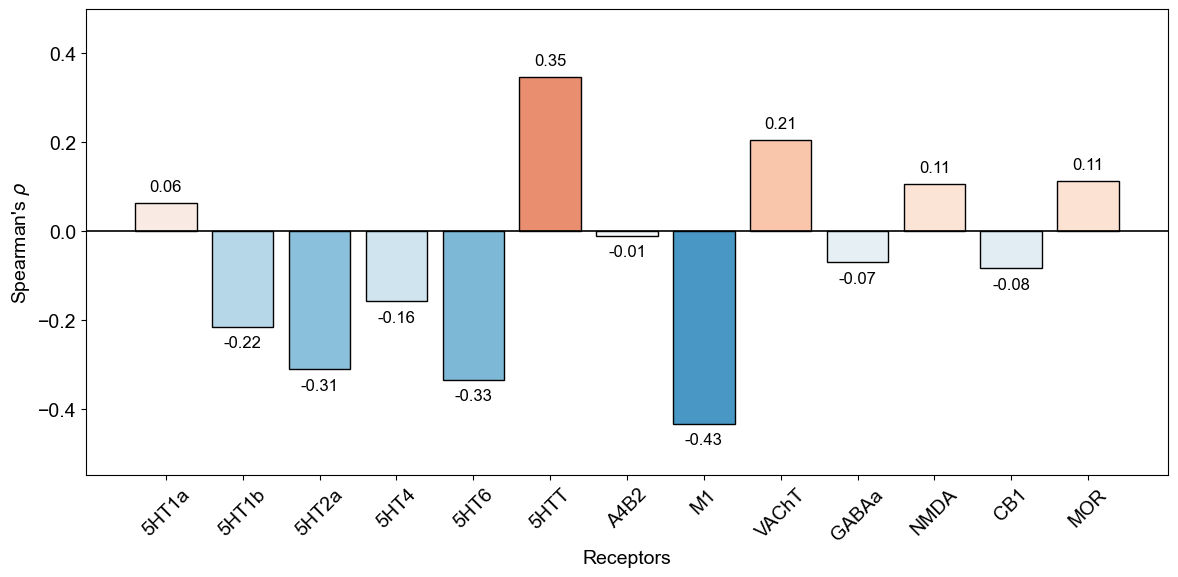

In [ ]:
import matplotlib.patches as patches
from matplotlib.colors import Normalize
import seaborn as sns

spin_corrected_nts = {
    key: {
        'rho': corr_fooof_nts_ic_1000[key]['r_empirical'],
        'spin_corrected_pvalues': correction_dict[key]
    }
    for key in corr_fooof_nts_ic_1000.keys()
}

# Extract data
names = list(spin_corrected_nts.keys())
rho_values = [spin_corrected_nts[k]['rho'] for k in names]
p_values = [spin_corrected_nts[k]['spin_corrected_pvalues'] for k in names]

# Normalize rho values to map to RdBu_r colormap
norm = Normalize(vmin=-0.75, vmax=0.75)
cmap = sns.color_palette("RdBu_r", as_cmap=True)
colors = [cmap(norm(r)) for r in rho_values]

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(names, rho_values, color=colors, edgecolor='black')
plt.xticks(rotation=45, ha='center', va='top')

ax = plt.gca()
for label in ax.get_xticklabels():
    label.set_x(0.08)  # slight tweak if needed

plt.ylim(-0.55, 0.5)
plt.axhline(y=0, color='black', linestyle='-', linewidth=1.2)
plt.xlabel('Receptors', fontsize = 14)
plt.ylabel(r"Spearman's $\rho$", fontsize = 14)

# Add value labels above bars
for bar in bars:
    height = bar.get_height()
    x = bar.get_x() + bar.get_width() / 2
    offset = 0.02
    y = height + offset if height >= 0 else height - offset
    va = 'bottom' if height >= 0 else 'top'
    plt.text(x, y, f'{height:.2f}', ha='center', va=va, fontsize=12)

plt.tight_layout()
plt.show()

#### RESTING STATE FOOOF ANALYSES ####

In [ ]:
# interict_fooof = load_aperiodic_from_mat_files("G:\Drive condivisi\AnalisiSegnaliEeg\HD EEG\Crisi_HDEEG\SPRINT_resting")

In [ ]:
with open("G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\SPRINT_resting\\resting_fooof.pkl", 'rb') as f:
    interictal_fooof = pickle.load(f)

In [ ]:
exponent_list_interictal = np.array(list(interictal_fooof.values()))
### CALCULAING THE AVERAGE FOOOF x ROI APERIODIC EXPONENT ###
average_fooof_interictal = np.mean(exponent_list_interictal, axis=0)

In [ ]:
list_indices_interictal = [(key.split('_sz')[0], value) for key, value in list_indices]
list_indices_interictal = natsorted(tuple(set(list_indices_interictal)))

# removing 2 subjects that are not in the fooof exp interictal data
for index in [18,10]:
    del list_indices_interictal[index]

In [36]:
def process_fooof_exp(fooof_dict, list_indices, normalized="per ROIs"):
    # Validate normalization method
    valid_normalization_options = {"none", "per ROIs", "per subject"}
    if normalized not in valid_normalization_options:
        raise ValueError(f"Invalid normalization option '{normalized}'. Choose from {valid_normalization_options}.")
    
    avg_selected , avg_not_selected = {}, {}
    # Process each ID and its corresponding indices
    for ID, indices in list_indices:
        if ID in fooof_dict:
            matrix = fooof_dict[ID]  # Shape (68, 120)

            # Convert indices from string to list of integers
            selected_indices = list(map(int, indices.split(",")))
            # Select columns corresponding to the indices
            selected_values = matrix[selected_indices, :]  # Shape (selected_indices, 120)
            not_selected_values = np.delete(matrix, selected_indices, axis=0)  # Remaining columns
            del matrix
            # Compute averages
            avg_selected[ID] = selected_values
            avg_not_selected[ID] = not_selected_values
            del selected_values, not_selected_values
    
    if normalized == "per ROIs":
        # Flatten all data into a single array for global mean/std
        all_selected_values = np.concatenate([values.reshape(-1) for values in avg_selected.values()])
        all_not_selected_values = np.concatenate([values.reshape(-1) for values in avg_not_selected.values()])

        # Compute global mean and std
        mean_all_selected, std_all_selected = np.mean(all_selected_values), np.std(all_selected_values)
        mean_all_not_selected, std_all_not_selected = np.mean(all_not_selected_values), np.std(all_not_selected_values)

        # Apply z-score normalization across all subjects
        for key in avg_selected:
            avg_selected[key] = (avg_selected[key] - mean_all_selected) / std_all_selected
        for key in avg_not_selected:
            avg_not_selected[key] = (avg_not_selected[key] - mean_all_not_selected) / std_all_not_selected

    elif normalized == "per subject":
        # Normalize each subject separately
        for key in avg_selected:
            mean_selected, std_selected = np.mean(avg_selected[key]), np.std(avg_selected[key])
            avg_selected[key] = (avg_selected[key] - mean_selected) / std_selected

        for key in avg_not_selected:
            mean_not_selected, std_not_selected = np.mean(avg_not_selected[key]), np.std(avg_not_selected[key])
            avg_not_selected[key] = (avg_not_selected[key] - mean_not_selected) / std_not_selected
    
    return avg_selected, avg_not_selected

In [ ]:
exp_selected_interictal, exp_non_selected_interictal = process_fooof_exp(interictal_fooof, list_indices_interictal, normalized='none') # dicts with 29 keys and values of shape (n, 120)
exp_selected_norm_interictal, exp_non_selected_norm_interictal = process_fooof_exp(interictal_fooof, list_indices_interictal, normalized='per ROIs') # dicts with 29 keys and values of shape (n, 120)
exp_selected_norm_glob_interictal, exp_non_selected_norm_glob_interictal = process_fooof_exp(interictal_fooof, list_indices_interictal, normalized='per subject') # dicts with 29 keys and values of shape (n, 120)


In [ ]:
exp_selected_interictal_average = np.mean(np.vstack(list(exp_selected_interictal.values())), axis = 0)
exp_non_selected_interictal_average = np.mean(np.vstack(list(exp_non_selected_interictal.values())), axis = 0)


se_selected, se_not_selected = [value for key, value in exp_selected_interictal.items()], [value for key, value in exp_non_selected_interictal.items()]
flattened_selected, flattened_not_selected = np.array([row for sublist in se_selected for row in sublist]), np.array([row for sublist in se_not_selected for row in sublist])

se_selected = np.std(flattened_selected, axis=0, ddof=1) / np.sqrt(flattened_selected.shape[0])
se_not_selected = np.std(flattened_not_selected, axis=0, ddof=1) / np.sqrt(flattened_not_selected.shape[0])

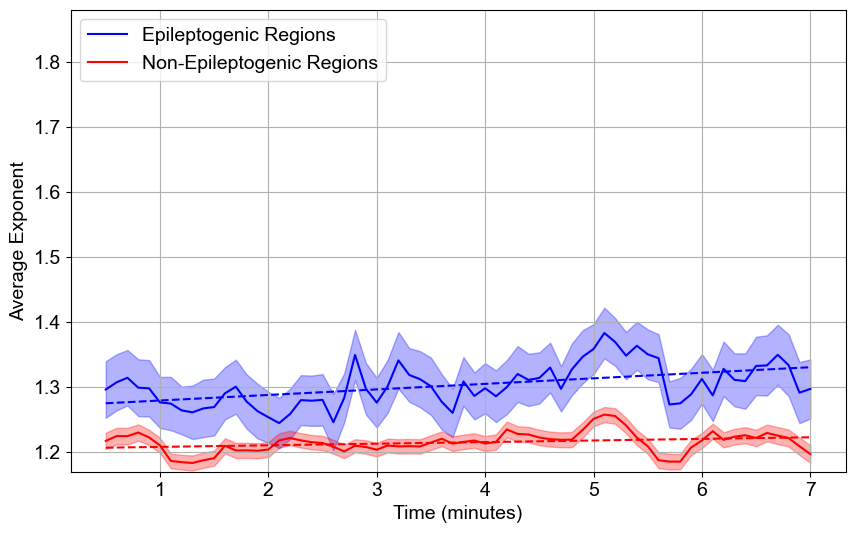

In [ ]:
exp_selected_interictal_average = np.mean(np.vstack(list(exp_selected_interictal.values())), axis = 0)
exp_non_selected_interictal_average = np.mean(np.vstack(list(exp_non_selected_interictal.values())), axis = 0)


se_selected, se_not_selected = [value for key, value in exp_selected_interictal.items()], [value for key, value in exp_non_selected_interictal.items()]
flattened_selected, flattened_not_selected = np.array([row for sublist in se_selected for row in sublist]), np.array([row for sublist in se_not_selected for row in sublist])

se_selected = np.std(flattened_selected, axis=0, ddof=1) / np.sqrt(flattened_selected.shape[0])
se_not_selected = np.std(flattened_not_selected, axis=0, ddof=1) / np.sqrt(flattened_not_selected.shape[0])

# Parameters
sampling_rate = 256  # Hz
signal_duration_sec = 7.5 * 60  # 780 seconds
window_length_sec = 60
step_size_sec = window_length_sec * (1 - 0.9)  # 6 seconds
num_segments = 71  # already known

# Generate time vector (window centers) in seconds
window_start_times = np.arange(0, step_size_sec * num_segments, step_size_sec)
window_center_times = window_start_times + (window_length_sec / 2)

# Convert to minutes
window_center_times_min = (window_center_times / 60)[:66]

# Convert to minutes
# Plot the two time series
plt.figure(figsize=(10, 6))

# Plot Selected Indices with std halo
x1 = window_center_times_min
plt.plot(x1, exp_selected_interictal_average, label="Epileptogenic Regions", color="blue")
plt.fill_between(x1, exp_selected_interictal_average - se_selected, exp_selected_interictal_average + se_selected, color='blue', alpha=0.3)

coeffs_sel = np.polyfit(x1, exp_selected_interictal_average, 1)
plt.plot(x1, np.polyval(coeffs_sel, x1), linestyle='--', color='blue')

# Plot Non-Selected Indices with std halo
x2 = window_center_times_min
plt.plot(x2, exp_non_selected_interictal_average, label="Non-Epileptogenic Regions", color="red")
plt.fill_between(x2, exp_non_selected_interictal_average - se_not_selected, exp_non_selected_interictal_average + se_not_selected, color='red', alpha=0.3)

coeffs_non = np.polyfit(x2, exp_non_selected_interictal_average, 1)
plt.plot(x2, np.polyval(coeffs_non, x2), linestyle='--', color='red')

# Add labels and legend
plt.xlabel("Time (minutes)")
plt.ylabel("Average Exponent")
#plt.title("Pre-ictal")
plt.legend(loc = 'upper left')
plt.grid(True)
plt.ylim(1.17,1.88)

# Show the plot
plt.show()

#plt.savefig("G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\PLOTS\\immagini finali\\fig 1\\aperiodic_exponent_interictal_state.png", dpi = 700)

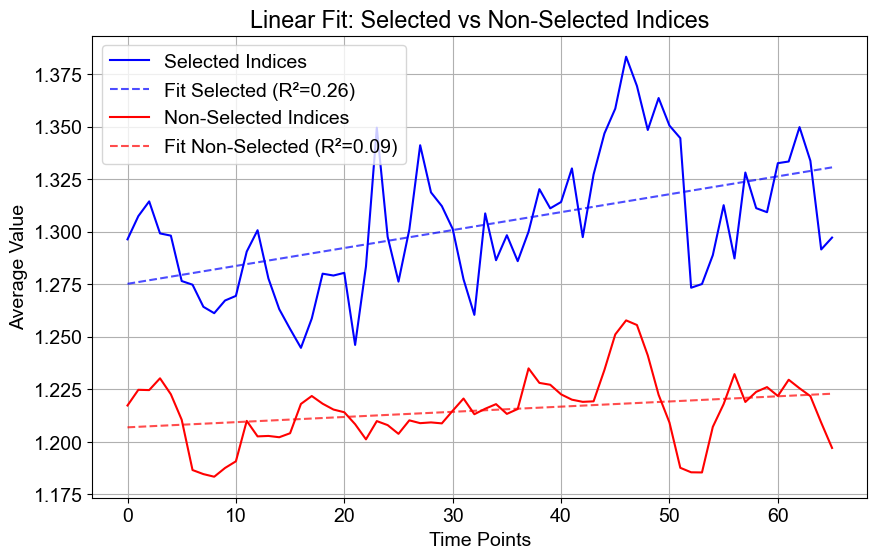

In [ ]:
from sklearn.metrics import r2_score

# Concatenate and average
exp_selected_interictal_avg = np.mean(np.concatenate(list(exp_selected_interictal.values()), axis=0), axis=0)
exp_non_selected_interictal_avg = np.mean(np.concatenate(list(exp_non_selected_interictal.values()), axis=0), axis=0)

# X-axis: time points
x = np.arange(len(exp_selected_interictal_avg))

# Linear fits
coeffs_sel = np.polyfit(x, exp_selected_interictal_avg, 1)
coeffs_non = np.polyfit(x, exp_non_selected_interictal_avg, 1)

y_fit_sel = np.polyval(coeffs_sel, x)
y_fit_non = np.polyval(coeffs_non, x)

# R² values
r2_sel = r2_score(exp_selected_interictal_avg, y_fit_sel)
r2_non = r2_score(exp_non_selected_interictal_avg, y_fit_non)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x, exp_selected_interictal_avg, label="Selected Indices", color="blue")
plt.plot(x, y_fit_sel, linestyle="--", color="blue", alpha=0.7, label=f"Fit Selected (R²={r2_sel:.2f})")

plt.plot(x, exp_non_selected_interictal_avg, label="Non-Selected Indices", color="red")
plt.plot(x, y_fit_non, linestyle="--", color="red", alpha=0.7, label=f"Fit Non-Selected (R²={r2_non:.2f})")

# Labels and title
plt.xlabel("Time Points")
plt.ylabel("Average Value")
plt.title("Linear Fit: Selected vs Non-Selected Indices")
plt.legend()
plt.grid(True)
plt.show()

In [42]:
import statsmodels.api as sm
import scipy.stats as stats

def p_value_slope(y):
    x = np.arange(len(y))
    # Fit OLS models
    model = sm.OLS(y, sm.add_constant(x)).fit()
    # Extract slopes and standard errors
    beta, se = model.params[1], model.bse[1]
    t_stat = model.tvalues[1]
    # Compute t-statistic
    p_value = model.pvalues[1]

    return {
        "slope": beta,
        "se": se,
        "t_stat": t_stat,
        "p_value": p_value
    }

In [ ]:
slope_exp_epilept_resting = p_value_slope(exp_selected_interictal_avg)

print(f'T-stat and Pvalue slope FOOOF exp in resting state Epileptogenics ROIs T:{slope_exp_epilept_resting["t_stat"]}, pval:{slope_exp_epilept_resting["p_value"]}, slope:{slope_exp_epilept_resting["slope"]}')

T-stat and Pvalue slope FOOOF exp in resting state Epileptogenics ROIs T:4.787356392655288, pval:1.0374020553388541e-05, slope:0.0008520645885246973


In [44]:
slope_exp_epilept_interict = p_value_slope(exp_selected_average)

print(f'T-stat and Pvalue slope FOOOF exp in interictal state Epileptogenics ROIs T:{slope_exp_epilept_interict["t_stat"]}, pval:{slope_exp_epilept_interict["p_value"]}, slope:{slope_exp_epilept_interict["slope"]}')

T-stat and Pvalue slope FOOOF exp in interictal state Epileptogenics ROIs T:13.872751534427046, pval:1.5135117306659154e-26, slope:0.0012580993069801838


In [ ]:
slope_exp_nonepilept_resting = p_value_slope(exp_non_selected_interictal_avg)

print(f'T-stat and Pvalue slope FOOOF exp in resting state NON Epileptogenics ROIs T:{slope_exp_nonepilept_resting["t_stat"]}, pval:{slope_exp_nonepilept_resting["p_value"]}, slope:{slope_exp_nonepilept_resting["slope"]}')

T-stat and Pvalue slope FOOOF exp in resting state NON Epileptogenics ROIs T:2.4866556066193684, pval:0.0155142372426917, slope:0.0002459760702287158


In [46]:
slope_exp_nonepilept_interict = p_value_slope(exp_non_selected_average)

print(f'T-stat and Pvalue slope FOOOF exp in interictal state NON Epileptogenics ROIs T:{slope_exp_nonepilept_interict["t_stat"]}, pval:{slope_exp_nonepilept_interict["p_value"]}, slope:{slope_exp_nonepilept_interict["slope"]}')

T-stat and Pvalue slope FOOOF exp in interictal state NON Epileptogenics ROIs T:15.177114665940032, pval:1.6426558416290487e-29, slope:0.0010970612172313322


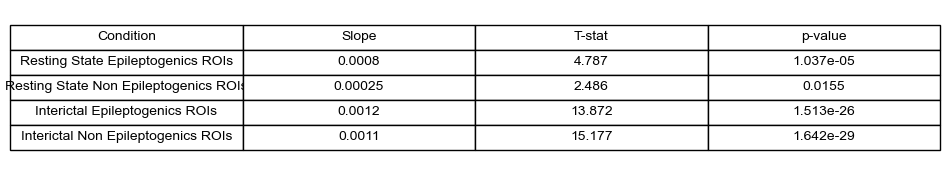

In [47]:
# Data
data = {
    "Condition": [
        "Resting State Epileptogenics ROIs",
        "Resting State Non Epileptogenics ROIs",
        "Interictal Epileptogenics ROIs",
        "Interictal Non Epileptogenics ROIs"
    ],
    "Slope": [0.0008, 0.00025, 0.0012, 0.0011],
    "T-stat": [4.787, 2.486, 13.872, 15.177],
    "p-value": [1.037e-05, 0.0155, 1.513e-26, 1.642e-29]
}

df = pd.DataFrame(data)

# Plot
fig, ax = plt.subplots(figsize=(10, 2))  # Adjust figure size as needed
ax.axis('tight')
ax.axis('off')

# Create table
table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc='center',
    colLoc='center',
    loc='center'
)

# Styling
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)  # Adjust as needed for better fit

# Save figure
#plt.savefig("scientific_table.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
comp_interictal_sel_nonsel = compare_slopes(exp_selected_interictal_avg, exp_non_selected_interictal_avg)
print(f"The result of the slopes comparison is T = {comp_interictal_sel_nonsel['t_stat']}, pvalue = {comp_interictal_sel_nonsel['p_value']}")

The result of the slopes comparison is T = 2.9765149649655687, pvalue = 0.004111635897322677


In [50]:
comp_sel_nonsel = compare_slopes(exp_selected_average, exp_non_selected_average)
print(f"The result of the slopes comparison is T = {comp_sel_nonsel['t_stat']}, pvalue = {comp_sel_nonsel['p_value']}")

The result of the slopes comparison is T = 1.3886014485210056, pvalue = 0.1675695683753768


In [ ]:
comp_sel_resting_vs_ictal = compare_slopes(exp_selected_average, exp_selected_interictal_avg)
print(f"The result of the slopes comparison is T = {comp_sel_resting_vs_ictal['t_stat']}, pvalue = {comp_sel_resting_vs_ictal['p_value']}")

The result of the slopes comparison is T = 2.032662628136052, pvalue = 0.046239957148146486


In [ ]:
comp_nonsel_resting_vs_ictal = compare_slopes(exp_non_selected_average, exp_non_selected_interictal_avg)
print(f"The result of the slopes comparison is T = {comp_nonsel_resting_vs_ictal['t_stat']}, pvalue = {comp_nonsel_resting_vs_ictal['p_value']}")

The result of the slopes comparison is T = 6.946807616815685, pvalue = 2.3063616164994577e-09
